<a href="https://colab.research.google.com/github/yash-mb/esctoolbox-python/blob/master/Loss_Function.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from numpy.random import *
import matplotlib.pyplot as plt
from numba import jit
import time

In [ ]:
nx = 80 # number of computational grids along x direction
ny = nx # number of computational grids along y direction
dx, dy = 2.0e-9, 2.0e-9 # spacing of computational grids [m]
c0 = 0.5 # average composition of B atom [atomic fraction]
R = 8.314 # gas constant
temp = 650 # temperature [K]
RT=R*temp
nsteps = 6000# total number of time-steps

In [ ]:
La = 20000.-9.*temp # Atom intaraction constant [J/mol]
ac = 3.0e-14
Da = 1.0e-04*np.exp(-300000.0/R/temp) # diffusion coefficient of A atom [m2/s]
Db = 2.0e-05*np.exp(-300000.0/R/temp) # diffusion coefficient of B atom [m2/s]
dt = (dx*dx/Da)*0.1 # time increment [s]
print(ac/La)

2.1201413427561837e-18


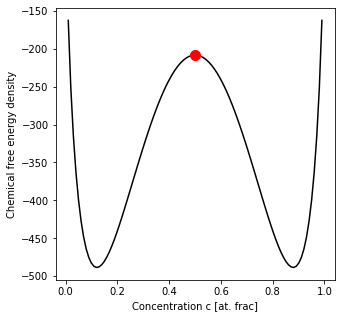

In [ ]:
fig = plt.figure(figsize=(5,5))
cc = np.linspace(0.01, 0.99, 100);
plt.plot(cc, R*temp*(cc*np.log(cc)+(1-cc)*np.log(1-cc))+La*cc*(1-cc),color='black')
plt.plot(c0, R*temp*(c0*np.log(c0)+(1-c0)*np.log(1-c0))+La*c0*(1-c0),color='r',marker='o',markersize=10)
plt.xlabel('Concentration c [at. frac]')
plt.ylabel('Chemical free energy density')
plt.show()

In [ ]:
c = np.zeros((nx,ny)) # order parameter c at time t
c_new = np.zeros((nx,ny)) # order parameter c at time t

In [ ]:

@jit(nopython=True)
def D_A_three(x, RT):
  return 1.0e-04*np.exp(-300000.0/RT)

@jit(nopython=True)
def D_B_three(x, RT):
  return 2.0e-05*np.exp(-300000.0/RT)
  
@jit(nopython=True)
def update_orderparameter(c, c_new, La, ac, RT, dx, dy, D_A_func, D_B_func,Da, Db, dt):
    for j in range(ny):
        for i in range(nx):
            
            ip = i + 1
            im = i - 1
            jp = j + 1
            jm = j - 1
            ipp = i + 2
            imm = i - 2
            jpp = j + 2
            jmm = j - 2

            if ip > nx-1:  # periodic boundary condition
                ip = ip - nx
            if im < 0:
                im = im + nx
            if jp > ny-1:
                jp = jp - ny
            if jm < 0:
                jm = jm + ny
            if ipp > nx-1: 
                ipp = ipp - nx
            if imm < 0:
                imm = imm + nx
            if jpp > ny-1:
                jpp = jpp - ny
            if jmm < 0:
                jmm = jmm + ny
            
            cc = c[i,j] # at (i,j) "centeral point"
            ce = c[ip,j] # at (i+1.j) "eastern point"
            cw = c[im,j] # at (i-1,j) "western point"
            cs = c[i,jm] # at (i,j-1) "southern point"
            cn = c[i,jp] # at (i,j+1) "northern point"
            cse = c[ip,jm] # at (i+1, j-1)
            cne = c[ip,jp]
            csw = c[im,jm]
            cnw = c[im,jp]
            cee = c[ipp,j]  # at (i+2, j+1)
            cww = c[imm,j]
            css = c[i,jmm]
            cnn = c[i,jpp]
            
            mu_chem_c = RT*(np.log(cc)-np.log(1.0-cc)) + La*(1.0-2.0*cc) # chemical term of the diffusion potential
            mu_chem_w = RT*(np.log(cw)-np.log(1.0-cw)) + La*(1.0-2.0*cw) 
            mu_chem_e = RT*(np.log(ce)-np.log(1.0-ce)) + La*(1.0-2.0*ce) 
            mu_chem_n = RT*(np.log(cn)-np.log(1.0-cn)) + La*(1.0-2.0*cn)  
            mu_chem_s = RT*(np.log(cs)-np.log(1.0-cs)) + La*(1.0-2.0*cs) 

            mu_grad_c = -ac*( (ce -2.0*cc +cw )/dx/dx + (cn  -2.0*cc +cs )/dy/dy ) # gradient term of the diffusion potential
            mu_grad_w = -ac*( (cc -2.0*cw +cww)/dx/dx + (cnw -2.0*cw +csw)/dy/dy )
            mu_grad_e = -ac*( (cee-2.0*ce +cc )/dx/dx + (cne -2.0*ce +cse)/dy/dy )  
            mu_grad_n = -ac*( (cne-2.0*cn +cnw)/dx/dx + (cnn -2.0*cn +cc )/dy/dy ) 
            mu_grad_s = -ac*( (cse-2.0*cs +csw)/dx/dx + (cc  -2.0*cs +css)/dy/dy )              
            
            mu_c = mu_chem_c + mu_grad_c # total diffusion potental
            mu_w = mu_chem_w + mu_grad_w 
            mu_e = mu_chem_e + mu_grad_e 
            mu_n = mu_chem_n + mu_grad_n 
            mu_s = mu_chem_s + mu_grad_s 
    
            nabla_mu = (mu_w -2.0*mu_c + mu_e)/dx/dx + (mu_n -2.0*mu_c + mu_s)/dy/dy    
            dc2dx2 = ((ce-cw)*(mu_e-mu_w))/(4.0*dx*dx)
            dc2dy2 = ((cn-cs)*(mu_n-mu_s))/(4.0*dy*dy) 

            Da3=D_A_three(cc,RT)
            Db3=D_B_three(cc,RT)
            mob = (1/RT)*(Da3*cc+Db3*(1.0-cc))
            dmdc = (1/RT)*(Da3-Db3+cc*Da+(1.0-cc)*Db*(2+2*cc))
            dcdt = mob*nabla_mu + dmdc*(dc2dx2 + dc2dy2) # right-hand side of Cahn-Hilliard equation
            c_new[i,j] = c[i,j] + dcdt *dt # update order parameter c 
    return c_new
  
@jit(nopython=True)
def update_full_orderparameter(c, c_new, La, ac, RT, dx, dy, D_A_func, D_B_func,Da, Db, dt):
    for j in range(ny):
        for i in range(nx):
            
            ip = i + 1
            im = i - 1
            jp = j + 1
            jm = j - 1
            ipp = i + 2
            imm = i - 2
            jpp = j + 2
            jmm = j - 2

            if ip > nx-1:  # periodic boundary condition
                ip = ip - nx
            if im < 0:
                im = im + nx
            if jp > ny-1:
                jp = jp - ny
            if jm < 0:
                jm = jm + ny
            if ipp > nx-1: 
                ipp = ipp - nx
            if imm < 0:
                imm = imm + nx
            if jpp > ny-1:
                jpp = jpp - ny
            if jmm < 0:
                jmm = jmm + ny
            
            cc = c[i,j] # at (i,j) "centeral point"
            ce = c[ip,j] # at (i+1.j) "eastern point"
            cw = c[im,j] # at (i-1,j) "western point"
            cs = c[i,jm] # at (i,j-1) "southern point"
            cn = c[i,jp] # at (i,j+1) "northern point"
            cse = c[ip,jm] # at (i+1, j-1)
            cne = c[ip,jp]
            csw = c[im,jm]
            cnw = c[im,jp]
            cee = c[ipp,j]  # at (i+2, j+1)
            cww = c[imm,j]
            css = c[i,jmm]
            cnn = c[i,jpp]

            mu_chem_c = RT*(np.log(cc)-np.log(1.0-cc)) + La*(1.0-2.0*cc)-RT*(np.log(1+2*cc+2*cc**2)-np.log(1+cc)) # chemical term of the diffusion potential
            mu_chem_w = RT*(np.log(cw)-np.log(1.0-cw)) + La*(1.0-2.0*cw)-RT*(np.log(1+2*cw+2*cw**2)-np.log(1+cw))
            mu_chem_e = RT*(np.log(ce)-np.log(1.0-ce)) + La*(1.0-2.0*ce)-RT*(np.log(1+2*ce+2*ce**2)-np.log(1+ce))
            mu_chem_n = RT*(np.log(cn)-np.log(1.0-cn)) + La*(1.0-2.0*cn)-RT*(np.log(1+2*cn+2*cn**2)-np.log(1+cn))
            mu_chem_s = RT*(np.log(cs)-np.log(1.0-cs)) + La*(1.0-2.0*cs)-RT*(np.log(1+2*cs+2*cs**2)-np.log(1+cs))

            mu_grad_c = -ac*( (ce -2.0*cc +cw )/dx/dx + (cn  -2.0*cc +cs )/dy/dy ) # gradient term of the diffusion potential
            mu_grad_w = -ac*( (cc -2.0*cw +cww)/dx/dx + (cnw -2.0*cw +csw)/dy/dy )
            mu_grad_e = -ac*( (cee-2.0*ce +cc )/dx/dx + (cne -2.0*ce +cse)/dy/dy )  
            mu_grad_n = -ac*( (cne-2.0*cn +cnw)/dx/dx + (cnn -2.0*cn +cc )/dy/dy ) 
            mu_grad_s = -ac*( (cse-2.0*cs +csw)/dx/dx + (cc  -2.0*cs +css)/dy/dy )              
            
            mu_c = mu_chem_c + mu_grad_c # total diffusion potental
            mu_w = mu_chem_w + mu_grad_w 
            mu_e = mu_chem_e + mu_grad_e 
            mu_n = mu_chem_n + mu_grad_n 
            mu_s = mu_chem_s + mu_grad_s 
    
            nabla_mu = (mu_w -2.0*mu_c + mu_e)/dx/dx + (mu_n -2.0*mu_c + mu_s)/dy/dy    
            dc2dx2 = ((ce-cw)*(mu_e-mu_w))/(4.0*dx*dx)
            dc2dy2 = ((cn-cs)*(mu_n-mu_s))/(4.0*dy*dy) 

            Da3=D_A_three(cc,RT)
            Db3=D_B_three(cc,RT)
            mob = (1/RT)*(Da3*cc+Db3*(1.0-cc))
            dmdc = (1/RT)*(Da3-Db3+cc*Da+(1.0-cc)*Db*(2+4*cc))
            dcdt = mob*nabla_mu + dmdc*(dc2dx2 + dc2dy2) # right-hand side of Cahn-Hilliard equation
            c_new[i,j] = c[i,j] + dcdt *dt # update order parameter c 
    return c_new

In [ ]:
ref = np.load ("Ref.npy", allow_pickle=True)

In [ ]:
ref_f = np.load ("ref_fourier.npy", allow_pickle=True)

In [ ]:
def get_loss(n, a, b) :
  La = a*20000.-9.*temp
  ac = b*3.0e-14
  L2_error = []
  n_steps = 1000
  dtt = 0

  for i in range (0, n):
    time_list = []
    mat_list = []
    marr = np.zeros((n_steps,1))
    ref = np.load ("Ref.npy", allow_pickle=True)
    c0 = 0.5
    c = np.zeros((nx,ny)) # zero-clear
    c_new = np.zeros((nx,ny)) # zero clear
    c = c0 + np.random.rand(nx, ny)*0.1
    dtt = 0

    for nstep in range(0, n_steps):
        dt=0.001*dx**2/Db
        dtt = dtt + dt
        c=update_orderparameter(c,c_new, La, ac, RT, dx, dy, D_A_three, D_B_three, Da, Db, dt)
        time_list.append (dtt)
        mat_list.append(c)
    
    marr = np.array (mat_list)
    #print('Maximum concentration = ', np.max(marr))
    #print('Minimum concentration = ', np.min(marr))
    #plt.imshow(marr[10], cmap='bwr')
    #plt.colorbar()
    #plt.show()
    k = 0
    L2 = 0
    for j in range (0, n_steps):
        L2 = np.linalg.norm(marr[j] - ref [j,1])
        k = k + L2
    L2_error.append(k)

  return L2_error

In [ ]:
def get_loss_fourier (n, a, b):
  La = a*20000.-9.*temp
  ac = b*3.0e-14
  L2_error = []
  n_steps = 1000

  for i in range (0, n):
    time_list = []
    mat_list = []
    marr = np.zeros((n_steps,1))
    ref = np.load ("Ref.npy", allow_pickle=True)
    c0 = 0.5
    c = np.zeros((nx,ny)) # zero-clear
    c_new = np.zeros((nx,ny)) # zero clear
    c = c0 + np.random.rand(nx, ny)*0.1
    dtt = 0

    for nstep in range(0, n_steps):
        dt=0.001*dx**2/Db
        dtt = dtt + dt
        c=update_orderparameter(c,c_new, La, ac, RT, dx, dy, D_A_three, D_B_three, Da, Db, dt)
        c_fourier = np.fft.fftshift(np.fft.fft2(c))
        #c_fourier = np.fft.fft2(c)
        time_list.append (dtt)
        mat_list.append(c_fourier)
    
    marr = np.array (mat_list)
    #print('Maximum concentration = ', np.max(marr))
    #print('Minimum concentration = ', np.min(marr))
    #plt.imshow(np.log(abs(marr[10])), cmap='bwr')
    #plt.colorbar()
    #plt.show()
    k = 0
    L2 = 0
    for j in range (0, n_steps):
        L2 = np.linalg.norm(np.log(abs(marr[j])) - np.log(abs(ref [j,1])))
        k = k + L2
    L2_error.append(k)

  return L2_error